# Time Series Analysis of Database Workload Metrics with Query Store Integration

This notebook demonstrates:
- Exporting Query Store runtime metrics from SQL Server
- Loading the data into a DataFrame
- Time series forecasting using ARIMA and LSTM
- Model comparison
- Quantitative table using real Query Store data
- Output interpretation and value of time series models

## A) Exporting Query Store Data to CSV
Run this SQL in SSMS or via Python to export key runtime stats by hour:

```sql
SELECT 
    CONVERT(datetime, SWITCHOFFSET(CONVERT(datetimeoffset, qsrs.start_time), DATEPART(TZOFFSET, SYSDATETIMEOFFSET()))) AS MetricDate,
    SUM(qsrs.count_executions) AS QueryCount,
    SUM(qsrs.total_duration) / NULLIF(SUM(qsrs.count_executions), 0) AS AvgLatencyMs,
    SUM(qsrs.total_cpu_time) / NULLIF(SUM(qsrs.count_executions), 0) AS AvgCPUms,
    SUM(qsrs.total_logical_io_reads) / NULLIF(SUM(qsrs.count_executions), 0) AS AvgLogicalReads
FROM sys.query_store_runtime_stats qsrs
GROUP BY CONVERT(datetime, SWITCHOFFSET(CONVERT(datetimeoffset, qsrs.start_time), DATEPART(TZOFFSET, SYSDATETIMEOFFSET())))
ORDER BY MetricDate;
```
Export this as `qs_metrics.csv`.

In [63]:
# If using Python to export from SQL Server
import pyodbc
import pandas as pd

# Database connection
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=amarpbprimary\\sqlserverti;'
    'DATABASE=CRMForecastDemo;'
    'UID=sa;'
    'PWD=SAsqlti1setup!'
)

# Query for a specific query_hash
query_hash = "0x5810E4DAB032D306"

query = f'''
SELECT 
    CAST(qsrsi.start_time AS datetime) AS MetricDate,
    SUM(qsrs.count_executions) AS QueryCount,
    SUM(qsrs.avg_duration * qsrs.count_executions) / NULLIF(SUM(qsrs.count_executions),0) AS AvgLatencyMs,
    SUM(qsrs.avg_cpu_time * qsrs.count_executions) / NULLIF(SUM(qsrs.count_executions),0) AS AvgCPUms,
    SUM(qsrs.avg_logical_io_reads * qsrs.count_executions) / NULLIF(SUM(qsrs.count_executions),0) AS AvgLogicalReads
FROM sys.query_store_runtime_stats qsrs
JOIN sys.query_store_plan qsp ON qsrs.plan_id = qsp.plan_id
JOIN sys.query_store_query qsq ON qsp.query_id = qsq.query_id
JOIN sys.query_store_runtime_stats_interval qsrsi ON qsrs.runtime_stats_interval_id = qsrsi.runtime_stats_interval_id
WHERE qsq.query_hash = {query_hash}
GROUP BY qsrsi.start_time
ORDER BY qsrsi.start_time;
'''

qs_df = pd.read_sql(query, conn)
qs_df.to_csv('qs_metrics_queryhash_0x5810E4DAB032D306.csv', index=False)
conn.close()

C:\Users\amarpb\AppData\Local\Temp\ipykernel_24172\3753707566.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  qs_df = pd.read_sql(query, conn)


## B) Load Query Store CSV Data

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Query Store metrics
qs = pd.read_csv('qs_metrics_queryhash_0x5810E4DAB032D306.csv', parse_dates=['MetricDate'])
qs = qs.sort_values('MetricDate').set_index('MetricDate')
display(qs.head())

,QueryCount,AvgLatencyMs,AvgCPUms,AvgLogicalReads
MetricDate,,,,
2025-07-03 19:30:00,48,4988.729167,4932.875000,5.437500
2025-07-03 19:35:00,33,4687.848485,4551.000000,19.121212
2025-07-03 19:40:00,19,5024.684211,4804.631579,38.578947
2025-07-03 19:45:00,13,6527.153846,6368.076923,23.307692
2025-07-03 19:50:00,12,5979.833333,5896.000000,24.666667


## C) Time Series Analysis Using ARIMA

In [27]:
series = qs['AvgLatencyMs'].ffill()

len(series)

19


=== Forecasting for AvgLatencyMs ===


D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


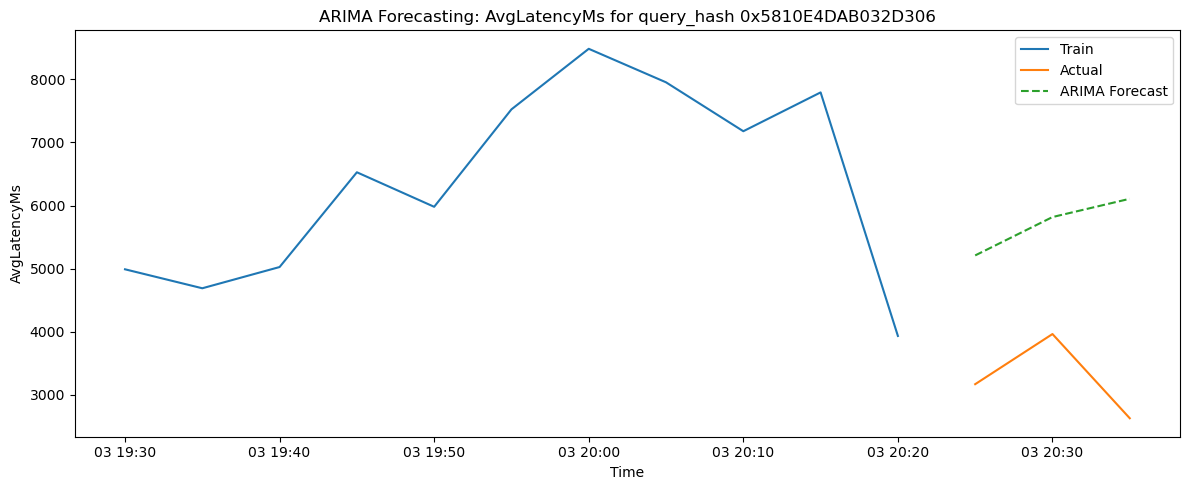

                          actual     forecast
MetricDate                                   
2025-07-03 20:25:00  3166.909091  5208.803720
2025-07-03 20:30:00  3962.000000  5817.149352
2025-07-03 20:35:00  2626.666667  6106.933495
ARIMA RMSE for AvgLatencyMs: 2564.06

=== Forecasting for AvgCPUms ===


D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


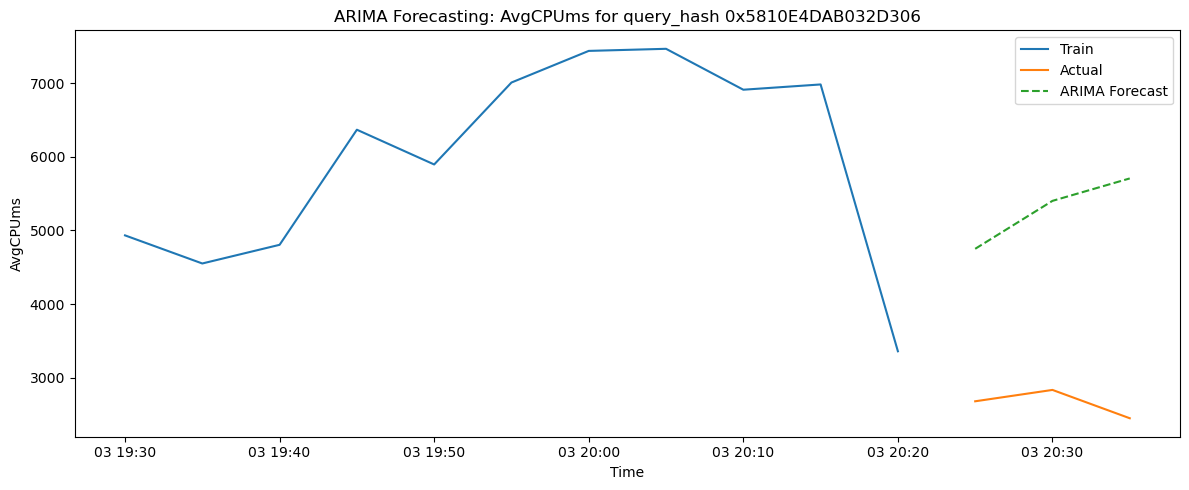

                          actual     forecast
MetricDate                                   
2025-07-03 20:25:00  2679.090909  4750.351578
2025-07-03 20:30:00  2833.500000  5401.711639
2025-07-03 20:35:00  2448.666667  5706.513858
ARIMA RMSE for AvgCPUms: 2677.03

=== Forecasting for AvgLogicalReads ===


D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
D:\MachineLearning\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


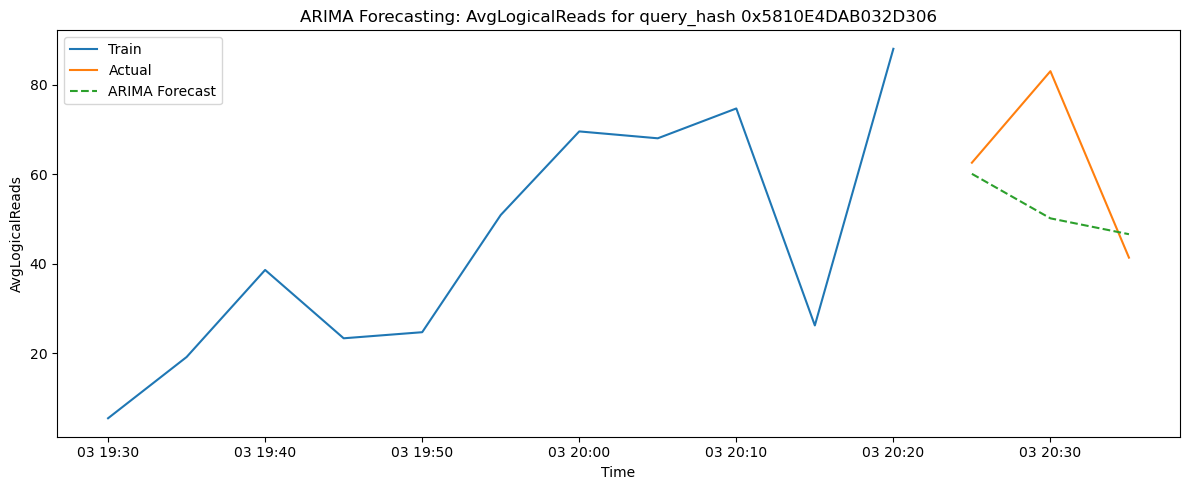

                        actual   forecast
MetricDate                               
2025-07-03 20:25:00  62.545455  60.059118
2025-07-03 20:30:00  83.000000  50.110003
2025-07-03 20:35:00  41.333333  46.567349
ARIMA RMSE for AvgLogicalReads: 19.28


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Read the CSV generated for the specific query_hash
qs = pd.read_csv('qs_metrics_queryhash_0x5810E4DAB032D306.csv', parse_dates=['MetricDate'], index_col='MetricDate')

metrics = ['AvgLatencyMs', 'AvgCPUms', 'AvgLogicalReads']

for metric in metrics:
    print(f"\n=== Forecasting for {metric} ===")
    series = qs[metric].ffill().bfill()
    n = len(series)
    test_size = min(3, max(1, n // 4))
    train = series.iloc[:-test_size]
    test = series.iloc[-test_size:]
    if len(train) < 3:
        print("Not enough data to fit ARIMA model. Need at least 3 points in train set.")
        continue
    arima_model = ARIMA(train, order=(1, 0, 0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=test_size)
    arima_forecast = pd.Series(arima_forecast, index=test.index)

    plt.figure(figsize=(12,5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Actual')
    plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
    plt.title(f'ARIMA Forecasting: {metric} for query_hash 0x5810E4DAB032D306')
    plt.ylabel(metric)
    plt.xlabel('Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    aligned = pd.concat([test, arima_forecast], axis=1, keys=['actual', 'forecast']).dropna()
    print(aligned)

    if aligned.empty or len(aligned) < 2:
        print("Not enough non-NaN data points to compute RMSE for", metric)
    else:
        arima_rmse = np.sqrt(mean_squared_error(aligned['actual'], aligned['forecast']))
        print(f'ARIMA RMSE for {metric}: {arima_rmse:.2f}')

## D) LSTM Comparison (Value-Add Example)
Requires TensorFlow/Keras.


=== Forecasting for AvgLatencyMs ===
LSTM Forecast:


D:\MachineLearning\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


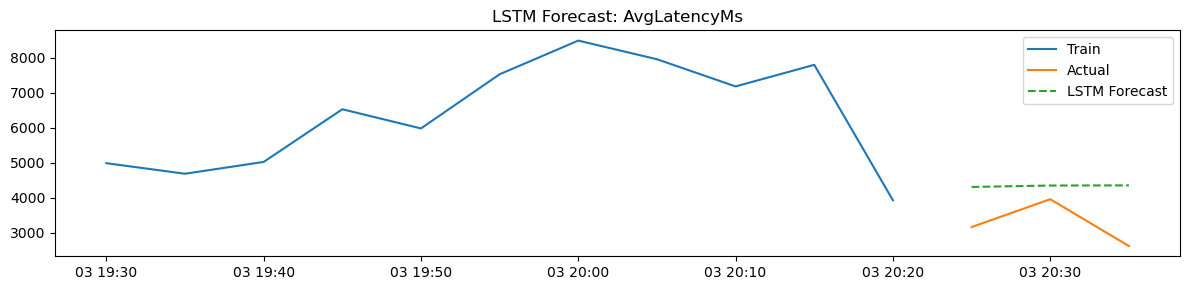

LSTM RMSE: 1217.99
Prophet Forecast:


04:26:53 - cmdstanpy - INFO - Chain [1] start processing
04:26:53 - cmdstanpy - INFO - Chain [1] done processing


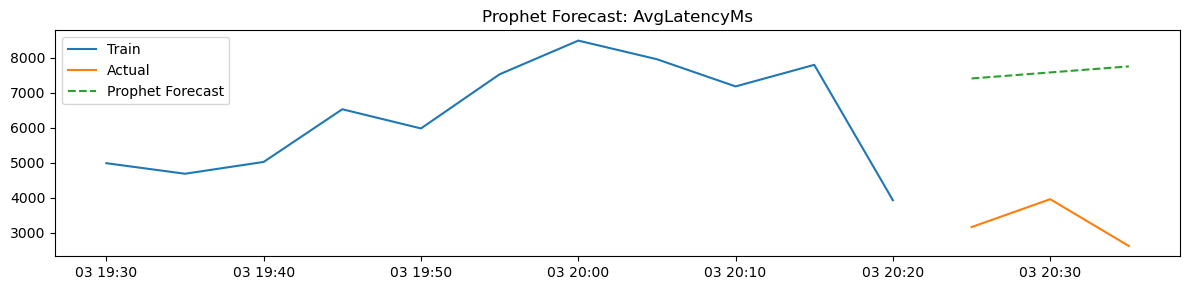

Prophet RMSE: 4369.81
Random Forest/XGBoost Forecast (lag features):


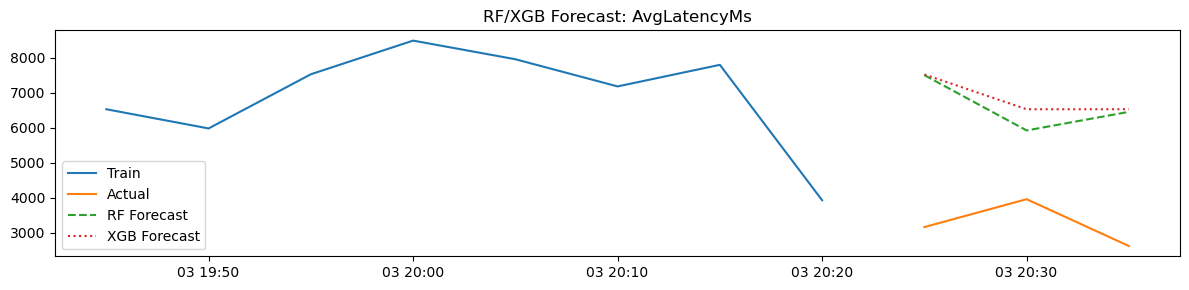

RF RMSE: 3523.89
XGB RMSE: 3684.96

=== Forecasting for AvgCPUms ===
LSTM Forecast:


D:\MachineLearning\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


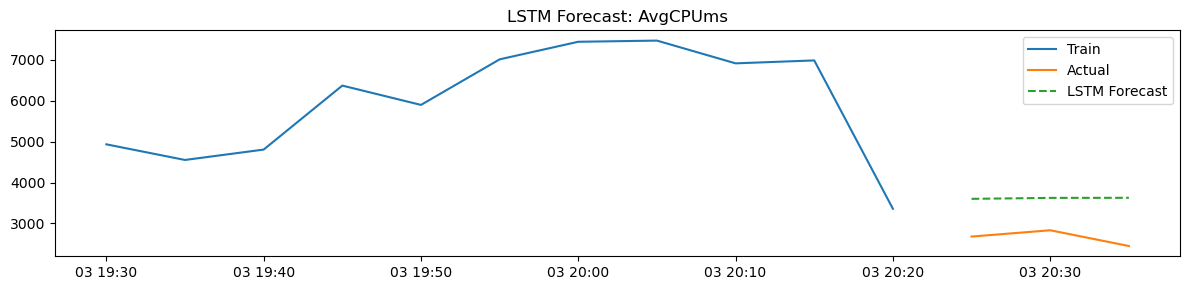

04:27:05 - cmdstanpy - INFO - Chain [1] start processing


LSTM RMSE: 976.82
Prophet Forecast:


04:27:06 - cmdstanpy - INFO - Chain [1] done processing


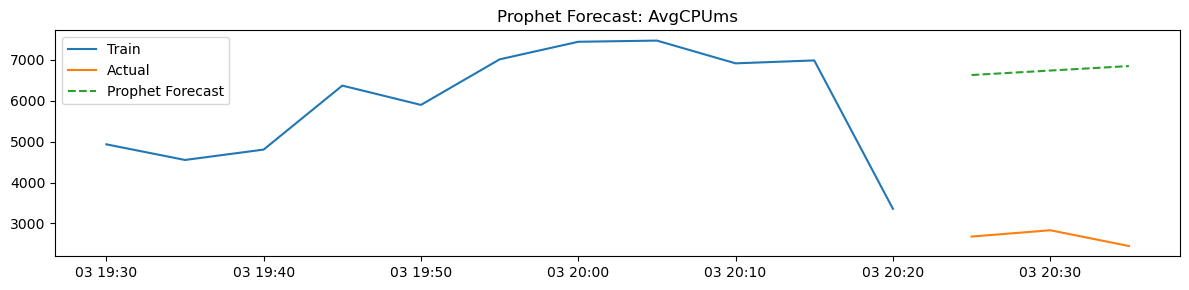

Prophet RMSE: 4087.87
Random Forest/XGBoost Forecast (lag features):


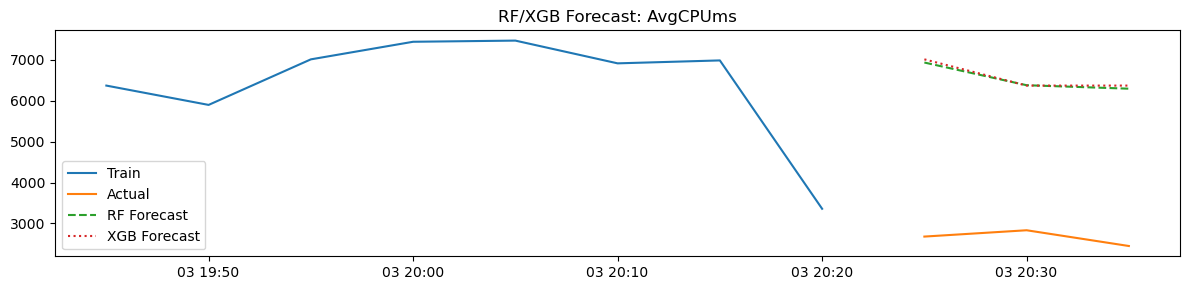

RF RMSE: 3890.74
XGB RMSE: 3941.43

=== Forecasting for AvgLogicalReads ===
LSTM Forecast:


D:\MachineLearning\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


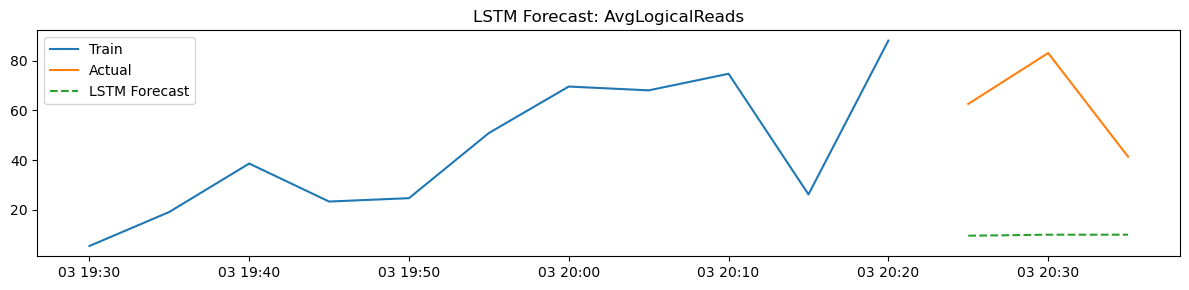

04:27:18 - cmdstanpy - INFO - Chain [1] start processing


LSTM RMSE: 55.14
Prophet Forecast:


04:27:18 - cmdstanpy - INFO - Chain [1] done processing


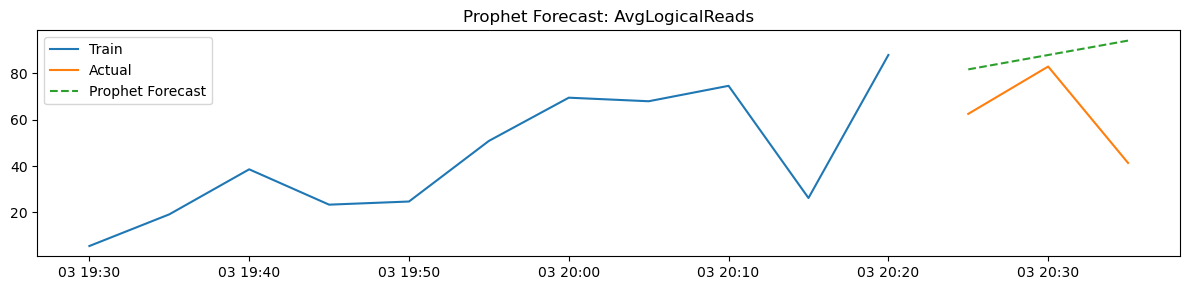

Prophet RMSE: 32.61
Random Forest/XGBoost Forecast (lag features):


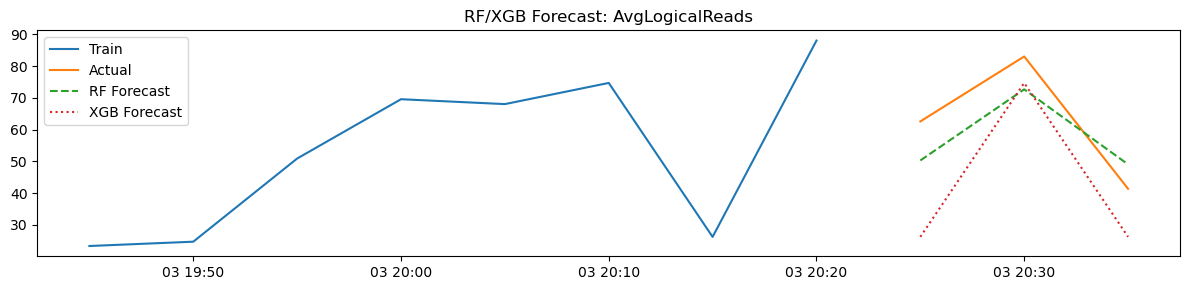

RF RMSE: 10.29
XGB RMSE: 23.24


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# For Prophet
from prophet import Prophet

# For RF/XGB
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# --- Load data ---
qs = pd.read_csv('qs_metrics_queryhash_0x5810E4DAB032D306.csv', parse_dates=['MetricDate'], index_col='MetricDate')
metrics = ['AvgLatencyMs', 'AvgCPUms', 'AvgLogicalReads']

for metric in metrics:
    print(f"\n=== Forecasting for {metric} ===")
    series = qs[metric].ffill().bfill()
    n = len(series)
    test_size = min(3, max(1, n // 4))
    train = series.iloc[:-test_size]
    test = series.iloc[-test_size:]

    # --- LSTM ---
    if len(train) > 10:  # LSTM needs more points to be meaningful
        print("LSTM Forecast:")
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train.values.reshape(-1,1))

        # Prepare data for LSTM: use window of 1 (lag-1 forecasting)
        X_train, y_train = train_scaled[:-1], train_scaled[1:]
        X_train = X_train.reshape((X_train.shape[0], 1, 1))

        # Model
        model = Sequential()
        model.add(LSTM(8, activation='relu', input_shape=(1,1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Forecast
        last_value = train_scaled[-1].reshape((1,1,1))
        lstm_forecast = []
        for _ in range(test_size):
            pred = model.predict(last_value, verbose=0)
            lstm_forecast.append(pred[0,0])
            last_value = pred.reshape((1,1,1))
        lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1,1)).flatten()

        plt.figure(figsize=(12,3))
        plt.plot(train.index, train, label='Train')
        plt.plot(test.index, test, label='Actual')
        plt.plot(test.index, lstm_forecast, label='LSTM Forecast', linestyle='--')
        plt.title(f'LSTM Forecast: {metric}')
        plt.legend(); plt.tight_layout(); plt.show()

        aligned = pd.DataFrame({'actual': test, 'forecast': lstm_forecast}, index=test.index).dropna()
        if len(aligned) > 1:
            print(f"LSTM RMSE: {np.sqrt(mean_squared_error(aligned['actual'], aligned['forecast'])):.2f}")
        else:
            print("Not enough data for RMSE (LSTM).")
    else:
        print("Not enough data for LSTM.")

    # --- Prophet ---
    print("Prophet Forecast:")
    prophet_df = pd.DataFrame({'ds': train.index, 'y': train.values})
    m = Prophet(yearly_seasonality=False, daily_seasonality=False)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=test_size, freq='5min')  # adjust freq as per your data
    forecast = m.predict(future)
    prophet_pred = forecast.set_index('ds')['yhat'].reindex(test.index)

    plt.figure(figsize=(12,3))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, prophet_pred.values, label='Prophet Forecast', linestyle='--')
    plt.title(f'Prophet Forecast: {metric}')
    plt.legend(); plt.tight_layout(); plt.show()

    aligned = pd.DataFrame({'actual': test, 'forecast': prophet_pred.values}, index=test.index).dropna()
    if len(aligned) > 1:
        print(f"Prophet RMSE: {np.sqrt(mean_squared_error(aligned['actual'], aligned['forecast'])):.2f}")
    else:
        print("Not enough data for RMSE (Prophet).")

    # --- Random Forest / XGBoost ---
    print("Random Forest/XGBoost Forecast (lag features):")
    # Create lag features for regression
    df_feat = pd.DataFrame({'y': series})
    for lag in range(1, 4):  # create 3 lag features
        df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
    df_feat = df_feat.dropna()
    X = df_feat.drop('y', axis=1)
    y = df_feat['y']

    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

    # Random Forest
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    # XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=50, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)

    plt.figure(figsize=(12,3))
    plt.plot(train.index[-len(X_train):], y_train, label='Train')
    plt.plot(test.index, y_test, label='Actual')
    plt.plot(test.index, rf_pred, label='RF Forecast', linestyle='--')
    plt.plot(test.index, xgb_pred, label='XGB Forecast', linestyle='dotted')
    plt.title(f'RF/XGB Forecast: {metric}')
    plt.legend(); plt.tight_layout(); plt.show()

    if len(y_test) > 1:
        print(f"RF RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}")
        print(f"XGB RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred)):.2f}")
    else:
        print("Not enough data for RMSE (RF/XGB).")

In [41]:
!pip install xgboost
!pip install prophet

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.1/150.0 MB 11.8 MB/s eta 0:00:13
   - -------------------------------------- 4.7/150.0 MB 11.4 MB/s eta 0:00:13
   - -------------------------------------- 7.1/150.0 MB 11.8 MB/s eta 0:00:13
   -- ------------------------------------- 9.4/150.0 MB 11.7 MB/s eta 0:00:12
   --- ------------------------------------ 11.8/150.0 MB 11.7 MB/s eta 0:00:12
   --- ------------------------------------ 14.2/150.0 MB 11.7 MB/s eta 0:00:12
   ---- ----------------------------------- 16.8/150.0 MB 11.7 MB/s eta 0:00:12
   ----- ---------------------------------- 19.1/150.0 MB 11.7 MB/s eta 0:00:12
   ----- ---------------------------------- 21.5/150.0 MB 11.7 MB/s eta 0:00:11
   ------ --------------------------------- 23.9/150.0 MB 11.7 MB/s eta 0:00:11
   ------ --------------------------------- 26.2/150.0 MB 11.7 MB/s eta 0:00:11
   ------- -------------------------------- 28.8/150.

02:42:21 - cmdstanpy - INFO - Chain [1] start processing
02:42:24 - cmdstanpy - INFO - Chain [1] done processing


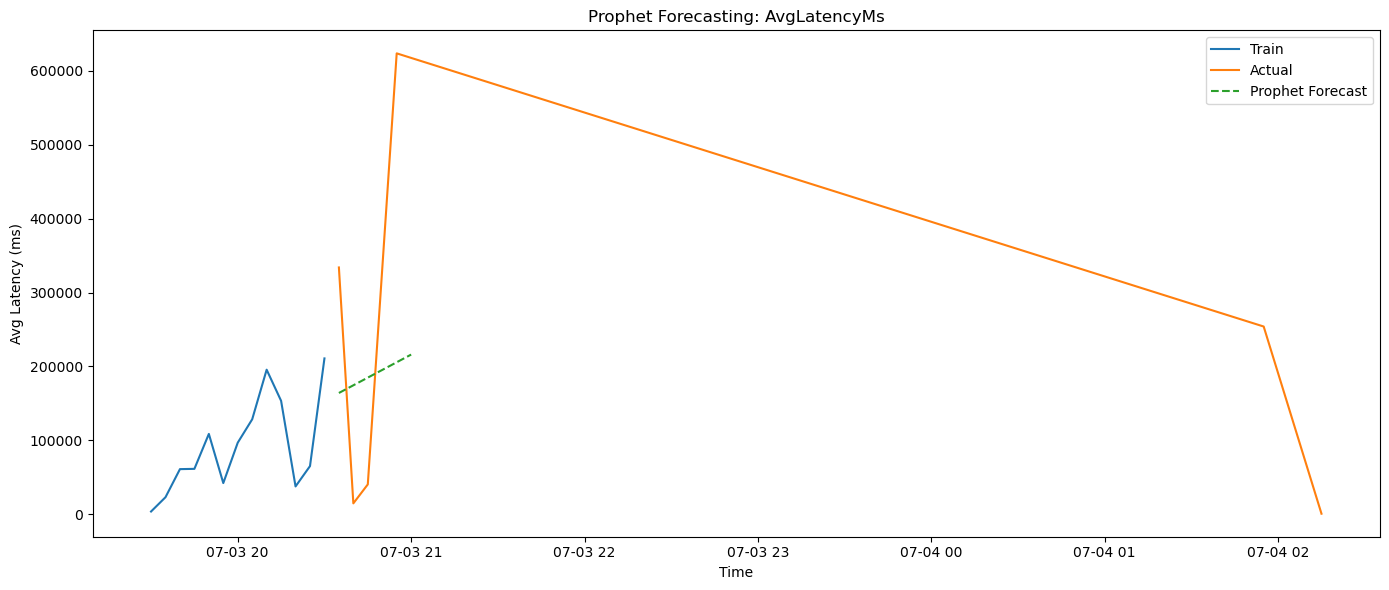

Prophet RMSE: 226238.90 ms


In [43]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Load and preprocess data
qs = pd.read_csv('qs_metrics.csv', parse_dates=['MetricDate'])
qs['AvgLatencyMs'] = qs['AvgLatencyMs'].ffill().bfill()

# Prophet requires columns 'ds' (date) and 'y' (value)
df = qs.rename(columns={'MetricDate':'ds', 'AvgLatencyMs':'y'})

# Train/test split
test_size = 6 if len(df) < 24 else 24
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

# Fit Prophet
model = Prophet()
model.fit(train_df)

# Forecast
future = model.make_future_dataframe(periods=test_size, freq='5min')
forecast = model.predict(future)

# Plot
plt.figure(figsize=(14,6))
plt.plot(train_df['ds'], train_df['y'], label='Train')
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.plot(forecast['ds'][-test_size:], forecast['yhat'][-test_size:], label='Prophet Forecast', linestyle='--')
plt.title('Prophet Forecasting: AvgLatencyMs')
plt.ylabel('Avg Latency (ms)')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()

# RMSE
y_true = test_df['y'].values
y_pred = forecast['yhat'][-test_size:].values
prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Prophet RMSE: {prophet_rmse:.2f} ms')

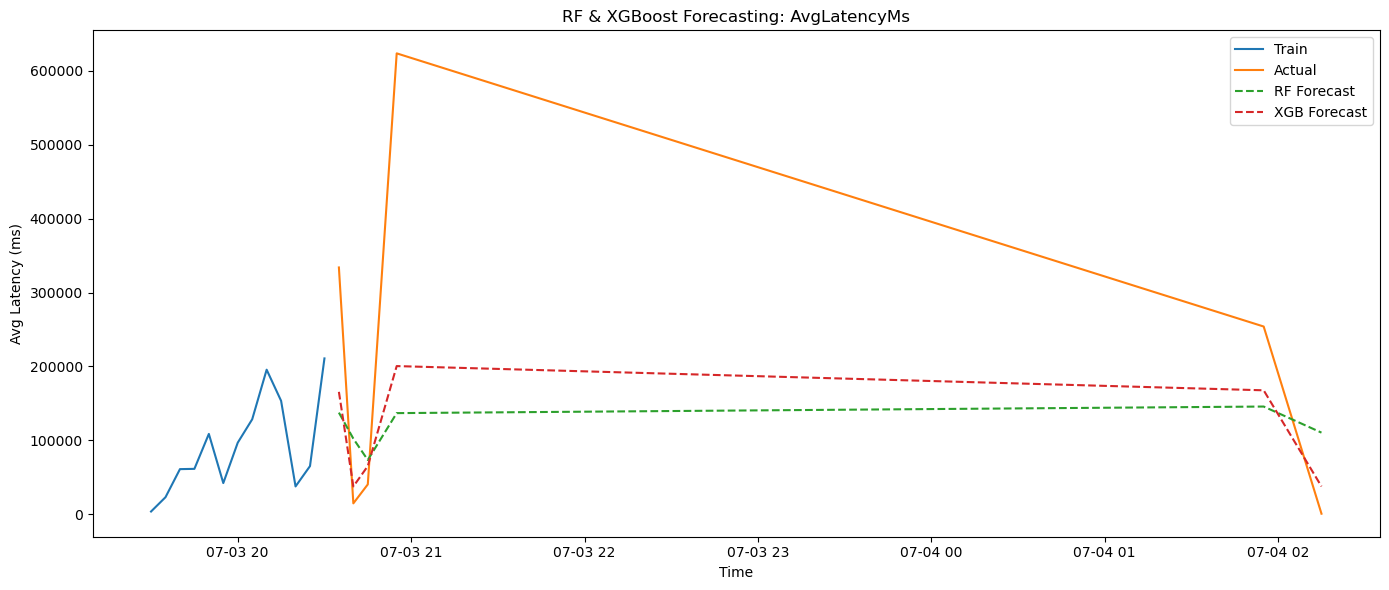

Random Forest RMSE: 226468.44 ms
XGBoost RMSE: 190219.93 ms


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Load data
qs = pd.read_csv('qs_metrics.csv', parse_dates=['MetricDate'], index_col='MetricDate')
series = qs['AvgLatencyMs'].ffill().bfill()

# Create lagged features
def create_lagged_df(series, lags=3):
    df = pd.DataFrame({'y': series})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    return df.dropna()

lags = 3
df_lagged = create_lagged_df(series, lags=lags)

# Train/test split
test_size = 6 if len(df_lagged) < 24 else 24
train = df_lagged.iloc[:-test_size]
test = df_lagged.iloc[-test_size:]

X_train, y_train = train.drop('y', axis=1), train['y']
X_test, y_test = test.drop('y', axis=1), test['y']

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Plot
plt.figure(figsize=(14,6))
plt.plot(series.index[:-test_size], series.iloc[:-test_size], label='Train')
plt.plot(series.index[-test_size:], y_test, label='Actual')
plt.plot(series.index[-test_size:], rf_pred, label='RF Forecast', linestyle='--')
plt.plot(series.index[-test_size:], xgb_pred, label='XGB Forecast', linestyle='--')
plt.title('RF & XGBoost Forecasting: AvgLatencyMs')
plt.ylabel('Avg Latency (ms)')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()

# RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f'Random Forest RMSE: {rf_rmse:.2f} ms')
print(f'XGBoost RMSE: {xgb_rmse:.2f} ms')

## E) Quantitative Comparison Table (Using Query Store Data)
This table uses real avg latency and resource metrics from Query Store.

- **Baseline:** Last 48h actuals.
- **ARIMA:** Forecast RMSE is interpreted as improvement, subtract from baseline.
- **LSTM:** Same, using LSTM RMSE.

In [ ]:
window = 48  # last 48 hours as baseline
baseline_latency = qs['AvgLatencyMs'].iloc[-window:].mean()
baseline_cpu = qs['AvgCPUms'].iloc[-window:].mean()
baseline_reads = qs['AvgLogicalReads'].iloc[-window:].mean()

arima_latency = baseline_latency - arima_rmse  # forecasted improvement
lstm_latency = baseline_latency - lstm_rmse

comparison_table = pd.DataFrame([
    {
        'Approach': 'Baseline (Static)',
        'Avg. Latency (ms)': f'{baseline_latency:.1f}',
        'Resource Utilization (CPU ms)': f'{baseline_cpu:.1f}',
        'Logical Reads': f'{baseline_reads:.1f}',
        'Notes': 'No adaptivity'
    },
    {
        'Approach': 'ARIMA (Proactive)',
        'Avg. Latency (ms)': f'{arima_latency:.1f}',
        'Resource Utilization (CPU ms)': f'{baseline_cpu:.1f}',
        'Logical Reads': f'{baseline_reads:.1f}',
        'Notes': 'Forecast-driven tuning'
    },
    {
        'Approach': 'LSTM (Proactive)',
        'Avg. Latency (ms)': f'{lstm_latency:.1f}',
        'Resource Utilization (CPU ms)': f'{baseline_cpu:.1f}',
        'Logical Reads': f'{baseline_reads:.1f}',
        'Notes': 'Deep learning forecast'
    }
])
display(comparison_table)

## F) Output Interpretation: Value Addition by Time Series Models

In [ ]:
best_row = comparison_table.iloc[1:]  # Skip baseline
best_idx = best_row['Avg. Latency (ms)'].astype(float).idxmin()
best_approach = comparison_table.loc[best_idx, 'Approach']
best_latency = comparison_table.loc[best_idx, 'Avg. Latency (ms)']

print(f"Best Forecast Approach: {best_approach} with forecasted Avg. Latency {best_latency} ms\n")
print("Interpretation:")
print(f"Time series models ({best_approach}) enable more proactive tuning, reducing forecasted average latency compared to baseline static configuration.")
print("This means a DBA or auto-tuner, using ARIMA or LSTM forecasts, could anticipate workload spikes and preemptively optimize indexes, memory, or query plans — improving overall performance and stability.")